## 02: Data Preparation

1. Here we construct our dataset for use in the experiment.

In [2]:
# import required libraries
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import random
import libs.utils as utils
import libs.bounding_box as bounding_box
import libs.patch_tools as patch_tools
import libs.data_prep as data_prep
import libs.train_test_split as tts
import libs.importing as importing
import libs.render as render
import libs.stats as stats
import libs.patch_tools as patch_tools
from importlib import reload


# set the random seed for we always get the same results (for now)
random.seed(42)


In [4]:
# GENERATE DATASET ID
exp_id = utils.short_id()
# use same data
exp_id = '940b74a8'
print('ID: {}'.format(exp_id))

ID: 940b74a8


In [5]:
# COPY DATA and SETUP EXPERIMENT
base_dir = '../source_dataset/all_v1'
data_prep.setup_experiment(base_dir, exp_id)

In [6]:
# 2-CLASS PROBLEM : Benign v. Papilloma

# SETUP : GET ALL CONTOURS
roi_df = pd.read_csv(os.path.join(exp_id, 'contours.csv'))
roi_2class = roi_df.copy()

# SELECT : only benign and papilloma labeled contours
roi_2class = roi_2class[roi_2class.label.isin([1,3,4])].reset_index(drop=True)

# combine all dysplasias and carcinomas
roi_2class.loc[roi_2class['label'] == 4, 'label'] = 3
roi_2class.loc[roi_2class['label'] == 3, 'label'] = 2

train2bp_df, test2bp_df, val2bp_df = tts.train_test_validation_split(roi_2class, classes=[1,2], samples=3)

# SAVE : save the results
train2bp_df.to_csv(os.path.join(exp_id, 'contours_train.csv'), index=False)
test2bp_df.to_csv(os.path.join(exp_id, 'contours_test.csv'), index=False)
val2bp_df.to_csv(os.path.join(exp_id, 'contours_val.csv'), index=False)

n: 77
distribution: [1 2] [30 47]
classes: [1 2], samples_per_class: 3
train-n: 65
test-n: 6
val-n: 6


In [7]:
# OR IF we've already run this notebook before we can just load the data
train2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
test2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
val2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))

In [8]:
# LOG : show all the contours we dumped and those we are using
#       these are logged at: 
#       [dumped] ./exp_id/log/eleminated_contours
#       [kept]   ./exp_id/log/experiment_contours
data_prep.show_contours_for_experiment(exp_id, roi_df, roi_2class)

total contours: 97
eliminated contours: 20
kept contours: 77


image_id        id          name  label
0   hgv-2d4a6a46  2a8db1fa  2a8db1fa.csv      2
1   hgv-8528141b  a58c9552  a58c9552.csv      2
2   hgv-8528141b  0f887b7a  0f887b7a.csv      2
3   hgv-99fc12a1  b257c7ff  b257c7ff.csv      2
4   hgv-99fc12a1  145037c7  145037c7.csv      2
5   hgv-99fc12a1  51b064d6  51b064d6.csv      2
6   hgv-99fc12a1  93d2c382  93d2c382.csv      2
7   hgv-2cdb69f6  935831de  935831de.csv      2
8   hgv-2cdb69f6  182410a0  182410a0.csv      2
9   hgv-2cdb69f6  2b225cd3  2b225cd3.csv      2
10  hgv-ff91c0a9  1642ec96  1642ec96.csv      2
11  odi-a981441f  415e5e1d  415e5e1d.csv      2
12  odi-819f9608  0ab79a7b  0ab79a7b.csv      2
13  odi-ea593e69  1a234d1d  1a234d1d.csv      2
14  odi-bf734aed  fa157de2  fa157de2.csv      2
15  odi-bf734aed  ac6902ce  ac6902ce.csv      2
16  odi-bf734aed  05219377  05219377.csv      2
17  odi-bf734aed  d92db932  d92db932.csv      2
18  odi-bf734aed  a3bd3fb8  a3bd3fb8.csv      2
19  odi-897669a0  82ff0525  82ff0525.csv      2

In [9]:
# TRAIN : data setup
#       : creates a directory ./exp_id/train/  where all the images and contours for training are stored
#       : creates a directory ./exp_id/train/log/info, where the contours and labels for the training set are stored as images for debugging purposes. 
train_df  = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
data_prep.setup_component(exp_id, train_df, 'train')
data_prep.log_component_info(os.path.join(exp_id, 'train'))

In [10]:
# TEST : data setup
#       : creates a directory ./exp_id/test/  where all the images and contours for test data are stored
#       : creates a directory ./exp_id/test/log/info, where the contours and labels for the test set are stored as images for debugging purposes.
test_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
data_prep.setup_component(exp_id, test_df, 'test')
data_prep.log_component_info(os.path.join(exp_id, 'test'))

In [11]:
# VALIDATION : data setup
#       : creates a directory ./exp_id/val/  where all the images and contours for validation data are stored
#       : creates a directory ./exp_id/val/log/info, where the contours and labels for the validation set are stored as images for debugging purposes.
val_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))
data_prep.setup_component(exp_id, val_df, 'val')
data_prep.log_component_info(os.path.join(exp_id, 'val'))

In [12]:
# GENERATE PATCHES : training data
#                    logs information to ./exp_id/train/log/setup_patches, where it shows patches on the image before and after removal

# threshold : the percentage a patch needs to overlap with the contour polygon in order to not be discarded
# patch_overlap : the shift size, should be a value which generates a factor of 64 for instance 0.5*64 = 32, or 0.25 * 64 = 16, etc.
train_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'train'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

# inspect the structure of our patches.csv file
display(train_patches_df.head())

# see how many training patches we have 
print('count: {}'.format(len(train_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  hgv-44a1f2e3   2dd43905  0a090b18  0a090b18.jpg  762  674        2
1  hgv-44a1f2e3   2dd43905  64b6c41c  64b6c41c.jpg  794  674        2
2  hgv-44a1f2e3   2dd43905  d95ebd0c  d95ebd0c.jpg  826  674        2
3  hgv-44a1f2e3   2dd43905  cde0345e  cde0345e.jpg  858  674        2
4  hgv-44a1f2e3   2dd43905  7f13f56d  7f13f56d.jpg  890  674        2

count: 3844


In [13]:
# GENERATE PATCHES : test data
#                    logs information to ./exp_id/test/log/setup_patches, where it shows patches on the image before and after removal
test_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'test'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(test_patches_df.head())
print('count: {}'.format(len(test_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  hgv-8528141b   4cb5eb92  b6a71195  b6a71195.jpg  541   72        1
1  hgv-8528141b   4cb5eb92  d0916eaf  d0916eaf.jpg  509  104        1
2  hgv-8528141b   4cb5eb92  49dca1d8  49dca1d8.jpg  541  104        1
3  hgv-8528141b   4cb5eb92  02d1eef2  02d1eef2.jpg  573  104        1
4  hgv-8528141b   4cb5eb92  cdace0d2  cdace0d2.jpg  477  136        1

count: 366


In [14]:
# GENERATE PATCHES : validation data
#                    logs information to ./exp_id/val/log/setup_patches, where it shows patches on the image before and after removal
val_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'val'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(val_patches_df.head())
print('count: {}'.format(len(val_patches_df)))

image_id contour_id  patch_id    patch_name     x    y label_id
0  hgv-453fea32   12acd19b  2934cb7b  2934cb7b.jpg   963  348        1
1  hgv-453fea32   12acd19b  7e9fa356  7e9fa356.jpg   995  348        1
2  hgv-453fea32   12acd19b  1b9ea39b  1b9ea39b.jpg  1027  348        1
3  hgv-453fea32   12acd19b  c0a3b7d2  c0a3b7d2.jpg   899  380        1
4  hgv-453fea32   12acd19b  55df5ae5  55df5ae5.jpg   931  380        1

count: 278


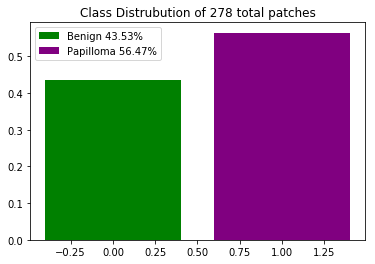

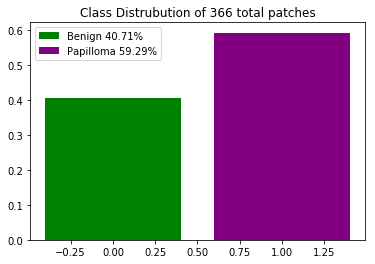

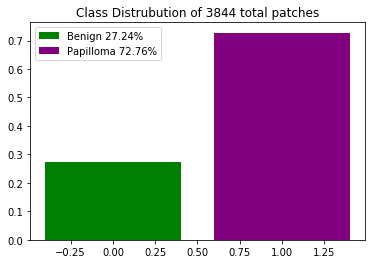

In [15]:
# BEFORE FILTERING PATCHES LOOK AT PATCH DISTRIBUTION
stats.plot_label_distribution(val_patches_df, labels=[1,2], label_key='label_id')
stats.plot_label_distribution(test_patches_df, labels=[1,2], label_key='label_id')
stats.plot_label_distribution(train_patches_df, labels=[1,2], label_key='label_id')

In [16]:
# FILTER PATCHES : some patches have way too much light or are just bad quality
#                  here we filter out patches which are so specular they contain very little information
#                  see: filtered patches are drawn onto the image at : ./exp_id/{train,test,val}/log/filter_highlight_patches - useful for debugging

train_dir = os.path.join(exp_id, 'train')
test_dir = os.path.join(exp_id, 'test')
val_dir = os.path.join(exp_id, 'val')

data_prep.filter_highlight_patches_for(train_dir, patch_size = 64, threshold=0.5)
data_prep.filter_highlight_patches_for(test_dir, patch_size = 64, threshold=0.5)
data_prep.filter_highlight_patches_for(val_dir, patch_size = 64, threshold=0.5)


bad patches: 55
before: 3844
cleaned: 3789
bad patches: 3
before: 366
cleaned: 363
bad patches: 0
before: 278
cleaned: 278


image_id contour_id  patch_id    patch_name     x    y  label_id
0    hgv-453fea32   12acd19b  2934cb7b  2934cb7b.jpg   963  348         1
1    hgv-453fea32   12acd19b  7e9fa356  7e9fa356.jpg   995  348         1
2    hgv-453fea32   12acd19b  1b9ea39b  1b9ea39b.jpg  1027  348         1
3    hgv-453fea32   12acd19b  c0a3b7d2  c0a3b7d2.jpg   899  380         1
4    hgv-453fea32   12acd19b  55df5ae5  55df5ae5.jpg   931  380         1
5    hgv-453fea32   12acd19b  b80fb9c6  b80fb9c6.jpg   963  380         1
6    hgv-453fea32   12acd19b  a514d5c5  a514d5c5.jpg   995  380         1
7    hgv-453fea32   12acd19b  2911a2d6  2911a2d6.jpg  1027  380         1
8    hgv-453fea32   12acd19b  6d0aecf1  6d0aecf1.jpg   899  412         1
9    hgv-453fea32   12acd19b  66039149  66039149.jpg   931  412         1
10   hgv-453fea32   12acd19b  b3ffcc93  b3ffcc93.jpg   963  412         1
11   hgv-453fea32   12acd19b  2db0df91  2db0df91.jpg   995  412         1
12   hgv-453fea32   12acd19b  d4f42f2a  d4f42f2a.jpg  1027  412         1
13   hgv-453fea32   12acd19b  7a5ea8f9  7a5ea8f9.jpg  1059  412         1
14   hgv-453fea32   12acd19b  cf15361a  cf15361a.jpg   931  444         1
15   hgv-453fea32   12acd19b  9c8b1096  9c8b1096.jpg   963  444         1
16   hgv-453fea32   12acd19b  543655e4  543655e4.jpg   995  444         1
17   hgv-453fea32   12acd19b  c777acc8  c777acc8.jpg  1027  444         1
18   hgv-453fea32   12acd19b  4e4b9d33  4e4b9d33.jpg  1059  444         1
19   hgv-453fea32   12acd19b  2d2383a6  2d2383a6.jpg   931  476         1
20   hgv-453fea32   12acd19b  771c4c62  771c4c62.jpg   963  476         1
21   hgv-453fea32   12acd19b  d56a0c7e  d56a0c7e.jpg   995  476         1
22   hgv-453fea32   12acd19b  6b78c076  6b78c076.jpg  1027  476         1
23   hgv-453fea32   12acd19b  ef0a3db9  ef0a3db9.jpg  1059  476         1
24   hgv-453fea32   12acd19b  ed1cf8a1  ed1cf8a1.jpg  1091  476         1
25   hgv-453fea32   12acd19b  8f911172  8f911172.jpg   963  508         1
26   hgv-453fea32   12acd19b  2cfe0f7d  2cfe0f7d.jpg   995  508         1
27   hgv-453fea32   12acd19b  b2aba090  b2aba090.jpg  1027  508         1
28   hgv-453fea32   12acd19b  3af69f83  3af69f83.jpg  1059  508         1
29   hgv-453fea32   12acd19b  e0e8eda4  e0e8eda4.jpg  1091  508         1
..            ...        ...       ...           ...   ...  ...       ...
248  mdi-9ce9698b   2bac5541  a44e5d2f  a44e5d2f.jpg   628  313         2
249  mdi-9ce9698b   2bac5541  6b8a4adc  6b8a4adc.jpg   660  313         2
250  mdi-9ce9698b   2bac5541  d9697215  d9697215.jpg   692  313         2
251  mdi-9ce9698b   2bac5541  2cc15889  2cc15889.jpg   724  313         2
252  mdi-9ce9698b   2bac5541  54e4e161  54e4e161.jpg   756  313         2
253  mdi-9ce9698b   2bac5541  166d9b63  166d9b63.jpg   788  313         2
254  mdi-9ce9698b   2bac5541  a660b04f  a660b04f.jpg   820  313         2
255  mdi-9ce9698b   2bac5541  ad006432  ad006432.jpg   852  313         2
256  mdi-9ce9698b   2bac5541  b86e01c3  b86e01c3.jpg   660  345         2
257  mdi-9ce9698b   2bac5541  cce8278e  cce8278e.jpg   692  345         2
258  mdi-9ce9698b   2bac5541  34167a81  34167a81.jpg   724  345         2
259  mdi-9ce9698b   2bac5541  68fd2118  68fd2118.jpg   756  345         2
260  mdi-9ce9698b   2bac5541  06ed4a12  06ed4a12.jpg   788  345         2
261  mdi-9ce9698b   2bac5541  a57c205b  a57c205b.jpg   820  345         2
262  mdi-9ce9698b   2bac5541  5cba0c00  5cba0c00.jpg   852  345         2
263  mdi-9ce9698b   2bac5541  66fd4072  66fd4072.jpg   692  377         2
264  mdi-9ce9698b   2bac5541  bae1dedb  bae1dedb.jpg   724  377         2
265  mdi-9ce9698b   2bac5541  cf84e3a5  cf84e3a5.jpg   756  377         2
266  mdi-9ce9698b   2bac5541  0273fbcb  0273fbcb.jpg   788  377         2
267  mdi-9ce9698b   2bac5541  0f14abea  0f14abea.jpg   820  377         2
268  odi-b43ee406   057317a5  9ce385a4  9ce385a4.jpg   609  141         1
269  odi-b43ee406   057317a5  abbcc149  abbcc149.jpg   609  173         1
270  odi-b43e

In [17]:
## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

train_pdr = importing.PatchDataReader(os.path.join(train_dir, 'patches'), trainp_df)
test_pdr = importing.PatchDataReader(os.path.join(test_dir, 'patches'), testp_df)
val_pdr = importing.PatchDataReader(os.path.join(val_dir, 'patches'), valp_df)

train_img, train_labels = train_pdr.read_data()
test_img, test_labels = test_pdr.read_data()
val_img, val_labels = val_pdr.read_data()

display('train images: {}'.format(len(train_img)))
display('train labels: {}'.format(len(train_labels)))
display('test images: {}'.format(len(test_img)))
display('test labels: {}'.format(len(test_labels)))
display('val images: {}'.format(len(val_labels)))
display('val labels: {}'.format(len(val_img)))


'train images: 3789'

'train labels: 3789'

'test images: 363'

'test labels: 363'

'val images: 278'

'val labels: 278'

In [18]:
# CREATE SHUFFLED DATA

## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

idxs = data_prep.shuffle_indices(len(trainp_df))
shuffled_train_df = trainp_df.loc[idxs].reset_index(drop=True)
shuffled_train_df.to_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(testp_df))
shuffled_test_df = testp_df.loc[idxs].reset_index(drop=True)
shuffled_test_df.to_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(valp_df))
shuffled_val_df = valp_df.loc[idxs].reset_index(drop=True)
shuffled_val_df.to_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'), index=False)



In [19]:
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_pdr)
data_prep.log_patch_data_reader(test_dir, test_pdr)
data_prep.log_patch_data_reader(val_dir, val_pdr)